# Stance Detection with Unsupervised Data Augmentation
In this notebook, Unsupervised Data Augmentation (Xie Q. et al., 2019) is applied to stance detection. Overall, a classifier is fed labelled examples and unlabelled examples along with their modified clones as generated through data augmentations. The objective is to minimise the cross-entropy loss for the labelled examples and the divergence between the distributions for the original and modified unlabelled examples.

In [6]:
import torch
import pickle

In [161]:
from datasets import SemEval, SemEvalSeenUnlabelled
from torch import nn, optim
from bert import encode
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
import numpy as np
from math import ceil
from utils import get_batch, plot_confusion_matrix
from warnings import filterwarnings

In [126]:
filterwarnings("ignore")

## Utilities and Model Implementation

In [12]:
def tokenise(text):
    return text.split()

In [13]:
def join(tokens):
    return " ".join(tokens)

In [14]:
def swap(text, p):
    tokens = tokenise(text)
    for i, token in enumerate(tokens):
        if np.random.rand() < p:
            j = np.random.randint(len(tokens))
            tokens[i], tokens[j] = tokens[j], tokens[i]
    return join(tokens)

In [15]:
def delete(text, p):
    tokens = []
    for token in tokenise(text):
        if np.random.rand() > p or (token.startswith("#") or token.startswith("@")):
            tokens.append(token)
    return join(tokens)

In [16]:
def _modify(text, swap_p, delete_p):
    return swap(delete(text, delete_p), swap_p)

In [17]:
def modify(texts, swap_p, delete_p):
    return [_modify(text, swap_p, delete_p) for text in texts]

In [18]:
def augment(texts, targets, n, swap_p, delete_p):
    pairs = []
    for _ in range(n):
        for text, target in zip(texts, targets):
            pairs.append((_modify(text, swap_p, delete_p), text, target))
    return pairs

In [84]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(nn.Linear(768, 64), nn.ReLU(), nn.Linear(64, 3), nn.Softmax(dim=1))
        self.cross_entropy_loss_function = nn.CrossEntropyLoss()
        self.kl_div_loss_function = nn.KLDivLoss(reduction="batchmean")
        
    def forward(self, inputs, labels, original, modified):
        probabilities = self.classifier(inputs)
        cross_entropy = self.cross_entropy_loss_function(probabilities, labels)
        original_probabilities = self.classifier(original)
        modified_probabilities = self.classifier(modified)
        kl_div = self.kl_div_loss_function(torch.log(modified_probabilities), original_probabilities)
        objectives = (cross_entropy, kl_div)
        return probabilities, torch.argmax(probabilities, 1), (sum(objectives), objectives)

In [85]:
def get_model(state_dict=None):
    torch.manual_seed(42)
    model = Model().cuda()
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model

## Training

In [93]:
training, testing = SemEval.get_subtask_a_datasets("data/semeval/")

In [94]:
maximum_length = 77

In [95]:
training_inputs = encode(training.texts, training.targets, method="conditional-target", maximum_length=maximum_length).cuda(), torch.tensor(training.stances).cuda()
testing_inputs = encode(testing.texts, testing.targets, method="conditional-target", maximum_length=maximum_length).cuda(), torch.tensor(testing.stances).cuda()

In [96]:
unlabelled = SemEvalSeenUnlabelled("data/semeval/subtask_a_unlabelled.json")

In [97]:
pairs = augment(unlabelled.texts, unlabelled.targets, 1, 0.1, 0.2)

In [158]:
original_inputs = encode([z[0] for z in pairs], [z[2] for z in pairs], method="conditional-target", maximum_length=maximum_length).cuda(),
modified_inputs = encode([z[1] for z in pairs], [z[2] for z in pairs], method="conditional-target", maximum_length=maximum_length).cuda(),

In [99]:
batch_size, unlabelled_batch_size = 48, 48
batches, unlabelled_batches = ceil(len(training) / batch_size), ceil(len(unlabelled) / unlabelled_batch_size)
batches, unlabelled_batches

(61, 2)

In [149]:
model = get_model()

In [150]:
optimiser = optim.Adam(model.parameters(), lr=1e-4)

In [151]:
step = 0

In [152]:
optimal_score, optimal_model_state_dict = 0.0, None

In [153]:
results = {
    "training": {
        "cross_entropy_loss": [],
        "kl_divergence_loss": [],
        "f_1_2": [],
        "f_1_3": []
    },
    "testing": {
        "cross_entropy_loss": [],
        "kl_divergence_loss": [],
        "f_1_2": [],
        "f_1_3": []
    },
}

In [ ]:
while True:
    
    optimiser.zero_grad()
    model.zero_grad()
    
    labelled_batch = get_batch(step, batch_size, training_inputs)
    original_batch = get_batch(step, unlabelled_batch_size, original_inputs)
    modified_batch = get_batch(step, unlabelled_batch_size, modified_inputs)
    
    _, predictions, (loss, (cross_entropy_loss, kl_divergence_loss)) = model(*labelled_batch, *original_batch, *modified_batch)
    loss.backward()
    optimiser.step()
    
    results["training"]["cross_entropy_loss"].append(float(cross_entropy_loss))
    results["training"]["kl_divergence_loss"].append(float(kl_divergence_loss))
    
    scores = f1_score(labelled_batch[1].cpu(), predictions.cpu(), average=None)
    scores = (np.mean(scores[1:]), np.mean(scores[:]))
    
    results["training"]["f_1_2"].append(scores[0])
    results["training"]["f_1_3"].append(scores[1])
    
    _, predictions, (_, (cross_entropy_loss, kl_divergence_loss)) = model(*testing_inputs, *original_batch, *modified_batch)
    
    results["testing"]["cross_entropy_loss"].append(float(cross_entropy_loss))
    results["testing"]["kl_divergence_loss"].append(float(kl_divergence_loss))
    
    scores = f1_score(testing.stances, predictions.cpu(), average=None)
    scores = (np.mean(scores[1:]), np.mean(scores[:]))
    
    results["testing"]["f_1_2"].append(scores[0])
    results["testing"]["f_1_3"].append(scores[1])
    
    score = np.mean(scores)
    
    if score > optimal_score:
        optimal_score = score
        optimal_model_state_dict = deepcopy(model.state_dict())
        print("{}\t{}\t{}\t{}".format(step, *scores, score))

    step += 1

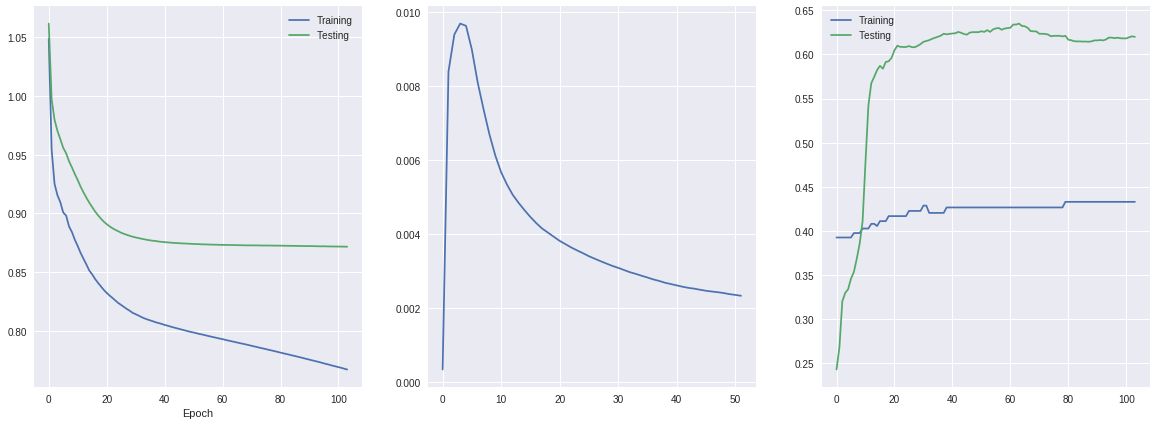

In [155]:
plt.figure(figsize=(20, 7))
plt.style.use("seaborn")

plt.subplot(1, 3, 1)
plt.plot(results["training"]["cross_entropy_loss"][::batches])
plt.plot(results["testing"]["cross_entropy_loss"][::batches])
plt.xlabel("Epoch")
plt.legend(["Training", "Testing"])

plt.subplot(1, 3, 2)
plt.plot(results["training"]["kl_divergence_loss"][::(batches * unlabelled_batches)])

plt.subplot(1, 3, 3)
plt.plot(results["training"]["f_1_2"][::batches])
plt.plot(results["testing"]["f_1_3"][::batches])
plt.legend(["Training", "Testing"])

## Evaluation

In [159]:
model = get_model(optimal_model_state_dict)

In [160]:
_, predictions, _ = model(*testing_inputs, *original_inputs, *modified_inputs)

In [162]:
print(classification_report(testing.stances, predictions.cpu()))

              precision    recall  f1-score   support

           0       0.53      0.62      0.57       230
           1       0.76      0.46      0.58       304
           2       0.72      0.80      0.76       715

    accuracy                           0.69      1249
   macro avg       0.67      0.63      0.63      1249
weighted avg       0.70      0.69      0.68      1249



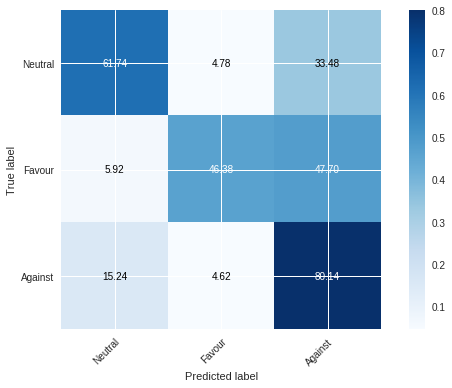

In [163]:
plot_confusion_matrix(testing.stances, predictions.cpu())